## Exploratory Data Analysis

We use this notebook to get familiar with the datasets we have. There are 10 questions we need to answer during the EDA.

In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [54]:
X = pd.read_csv('flights.csv')
X.head(20)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-01-01,B6,B6,B6,131,B6,N569JB,131,13204,MCO,...,2218,36.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN
1,2018-01-01,B6,B6,B6,132,B6,N569JB,132,12892,LAX,...,2218,2.0,0.0,0.0,0.0,25.0,NaN,NaN,NaN,NaN
2,2018-01-01,B6,B6,B6,135,B6,N547JB,135,12478,JFK,...,2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,B6,B6,B6,136,B6,N834JB,136,14107,PHX,...,2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,B6,B6,B6,144,B6,N354JB,144,10994,CHS,...,444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-01-01,B6,B6,B6,147,B6,N554JB,147,13796,OAK,...,353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-01,B6,B6,B6,148,B6,N554JB,148,12954,LGB,...,353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01,B6,B6,B6,149,B6,N935JB,149,12478,JFK,...,2378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-01-01,B6,B6,B6,150,B6,N935JB,150,14262,PSP,...,2378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-01-01,B6,B6,B6,153,B6,N592JB,153,12478,JFK,...,1028,9.0,0.0,17.0,0.0,15.0,NaN,NaN,NaN,NaN


In [526]:
#Checking wethear the data in the following four columns are the same in each row or not? then removing repetative cols
X1=X[['mkt_unique_carrier','branded_code_share','mkt_carrier','op_unique_carrier']]

rows_with_same_values=0

for i in range (len(X1)):
    if len(X1.iloc[0].unique())==1:
        rows_with_same_values+=1  
        
if rows_with_same_values==len(X1):
    X2= X.drop(columns=['branded_code_share','mkt_carrier','op_unique_carrier'])
    
# remove cancelled flights from my data set
X2=X2[X2['cancelled']==0]

# The departure time is formatted as hhmm, we get the first two strings to get the hour that a flight departs or arrives
X2['dep_time'] = day_avg['dep_time'].apply(lambda x: str(int(x)))
X2['dep_hour'] = day_avg['dep_time'].apply(lambda x: get_hour(x))
X2['arr_time'] = day_avg['arr_time'].apply(lambda x: str(int(x)))
X2['arr_hour'] = day_avg['arr_time'].apply(lambda x: get_hour(x))

X2.to_csv('../data/random_clean_sample.csv', index=False)

#### **Task 1**: Because delay is not normally distributed, we create a new column to have normal distribution + dealing with outliers + removing early arrivales

In [498]:
#adding a new column 'arr_delay_log' as the log of 'arr_delay'
X['arr_delay_log'] = X['arr_delay'].apply(lambda x: np.log(np.clip(x, 1, None)))

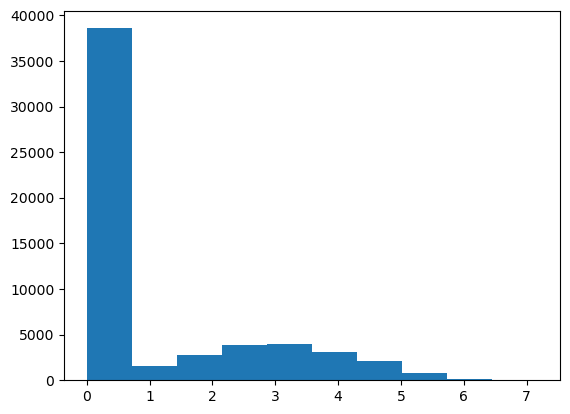

In [10]:
fig1 = plt.hist(X['arr_delay_log'])
plt.show()

#np.exp(...)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [500]:
from datetime import datetime
mon_del = X[['fl_date', 'arr_delay_log']]

mon_del['fl_date'] = mon_del['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
mon_del['month'] = mon_del['fl_date'].apply(lambda x: x.month)

In [501]:
mon_del_avg = mon_del.groupby('month').mean().reset_index()
mon_del_avg.head()

,month,arr_delay_log
0,1,0.979083
1,2,1.107593
2,3,0.866636
3,4,0.988663
4,5,1.072134


In [502]:
px.bar(mon_del_avg, x='month', y='arr_delay_log')

The largest delays occur during the summer months and the winter months. During the spring and the fall, the delays are smaller. Perhaps this is because of people travelling during the summer months during summer vacation and visiting during the christmas holidays. It is also possible that these are the months with the most extreme weather, windy rainstorms during the summer and snow during the winter.

#### **Task 3**: Does the weather affect the delay? 
We Used worldweatheronline API to pull the weather information for flights. Because, there is no need to get weather for ALL flights, we chose a representative sample of 450 and focused on four weather types:
- sunny
- cloudy
- rainy
- snowy

Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [505]:
pip install wwo-hist

Note: you may need to restart the kernel to use updated packages.


In [506]:
#importing libraries we need
from wwo_hist import retrieve_hist_data
import os
#deining where the output would be saved 
os.chdir("..\data")

In [509]:
X_weather=X2[['fl_date','origin_city_name','cancelled','arr_delay_log']]

#remove state name
X_weather_1['origin_city_name'] = X_weather_1['origin_city_name'].map(lambda x: str(x)[:-4])
#remove /  if any and delete anything after /
X_weather_1['origin_city_name'] = X_weather_1['origin_city_name'].str.split('/').str[0]
#replace space with dash if any
X_weather_1['origin_city_name'] = X_weather_1['origin_city_name'].str.replace(' ', '-')
#drop nulls
X_weather_1=X_weather_1.dropna(inplace=True)

In [510]:
#choose a random sample and call it df, it is commented to prevent running again by mistake
#df=X_weather_1.sample(450)

In [474]:
import requests
import json

endpoint_url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
api_key = os.environ['worldweatheronline_API_KEY']


for index, row in df.iterrows():
    location = row['origin_city_name']
    date = row['fl_date']
    params = {
        'key': api_key,
        'q': location,
        'date': date,
        'tp': '24',
        'format': 'json'
    }
    response = requests.get(endpoint_url, params=params)
    data = response.json()
    
    # Get weather type from API response
    weather_desc = data['data']['weather'][0]['hourly'][0]['weatherDesc'][0]['value']
    if 'sunny' in weather_desc.lower():
        df.loc[index, 'weather_type'] = 'sunny'
    elif 'cloud' in weather_desc.lower():
        df.loc[index, 'weather_type'] = 'cloudy'
    elif 'rain' in weather_desc.lower():
        df.loc[index, 'weather_type'] = 'rainy'
    elif 'snow' in weather_desc.lower():
        df.loc[index, 'weather_type'] = 'snowy'
    else:
        df.loc[index, 'weather_type'] = 'unknown'

In [512]:
df.to_csv('updated_flight_data.csv', index=False)
df=pd.read_csv('../data/updated_flight_data.csv')
df.head()

,fl_date,origin_city_name,cancelled,arr_delay_log,weather_type
0,2018-07-25,Chicago,0,4.406719,sunny
1,2019-05-12,Newark,0,2.833213,rainy
2,2019-01-12,Birmingham,0,0.000000,unknown
3,2018-06-20,Denver,0,0.000000,rainy
4,2018-12-17,Dallas,0,0.000000,cloudy


<AxesSubplot:xlabel='weather_type', ylabel='arr_delay_log'>

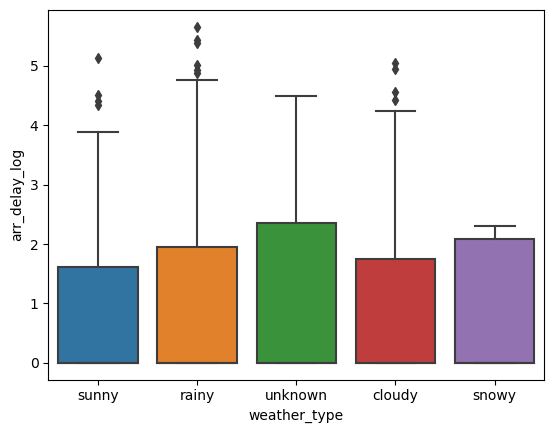

In [513]:
sns.boxplot(x='weather_type', y='arr_delay_log', data=df)

In [514]:
from scipy.stats import kruskal

cloudy = df[df['weather_type']=='cloudy']['arr_delay_log']
rainy = df[df['weather_type']=='rainy']['arr_delay_log']
snowy = df[df['weather_type']=='snowy']['arr_delay_log']
sunny = df[df['weather_type']=='sunny']['arr_delay_log']

stat, p = kruskal(cloudy, rainy, snowy, sunny)

alpha = 0.05
if p > alpha:
    print('The delays are from the same distribution (fail to reject H0)')
else:
    print('The delays are not from the same distribution (reject H0)')

The delays are from the same distribution (fail to reject H0)


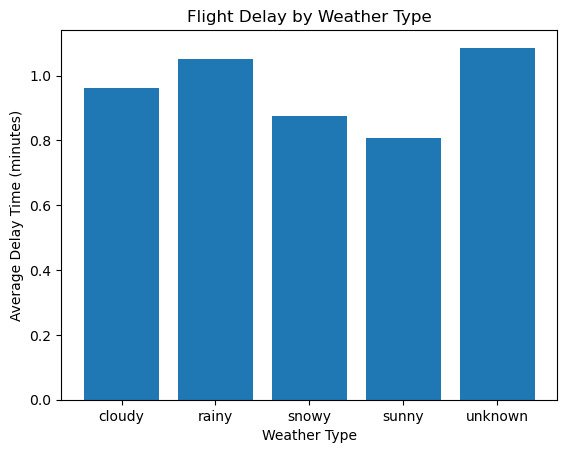

In [515]:
# group the data by weather type and calculate the average delay time for each group
delay_by_weather_type = aaa.groupby('weather_type')['arr_delay_log'].mean()

# create a bar chart of the average delay time by weather type
plt.bar(delay_by_weather_type.index, delay_by_weather_type.values)
plt.xlabel('Weather Type')
plt.ylabel('Average Delay Time (minutes)')
plt.title('Flight Delay by Weather Type')
plt.show()

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [518]:
# The departure time is formatted as hhmm, we get the first two strings to get the hour that a flight departs
# and then group by this to find average taxi time
taxi_time = X[['dep_time', 'taxi_out','arr_delay_log']]
# taxi_time.isna().sum()
taxi_time.dropna(inplace=True)
taxi_time['dep_time'] = taxi_time['dep_time'].apply(lambda x: str(int(x)))

In [519]:
def get_hour(x):
    if len(x) == 4:
        return int(x[:2])
    return int(x[0])

In [520]:
taxi_time['hour'] = taxi_time['dep_time'].apply(lambda x: get_hour(x))
taxi_avg = taxi_time.groupby('hour').mean().reset_index()
#taxi_avg

In [521]:
px.bar(taxi_avg, x='hour', y='taxi_out')

It looks like there is a small dip in taxi time during the early hours of the day after midnight, increasing during the morning around 7 AM. This makes sense as there should be fewer flights during the early morning hours, which people prefer not to fly at these hours.

In [20]:
taxi_count = taxi_time.groupby('hour').count().reset_index()
px.bar(taxi_count, x='hour', y='taxi_out')

In [522]:
co_rel=pd.merge(taxi_count,taxi_avg,on='hour',how='inner')
co_rel.head(2)


,hour,dep_time,taxi_out_x,arr_delay_log_x,taxi_out_y,arr_delay_log_y
0,1,145,145,145,15.386207,2.740912
1,2,76,76,76,13.907895,2.524234


<function matplotlib.pyplot.show(close=None, block=None)>

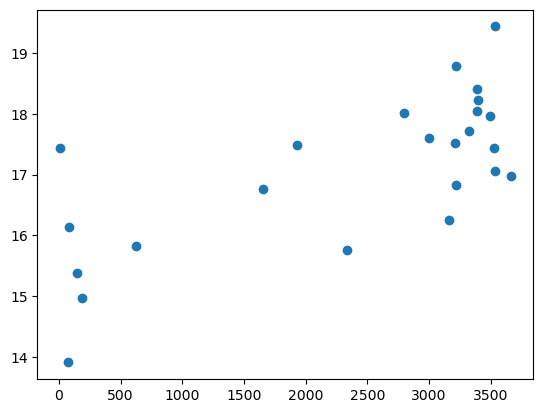

In [22]:
co_rel=pd.merge(taxi_count,taxi_avg,on='hour',how='inner')
co_rel=co_rel.drop('dep_time',axis=1)
co_rel=co_rel.rename(columns={'taxi_out_x': '#flights','taxi_out_y':'avg_taxi_out','arr_delay_log_y':'avg_delay'})
co_rel=co_rel.drop('arr_delay_log_x',axis=1)


correlation = co_rel['#flights'].corr(co_rel['avg_taxi_out'])


plt.scatter(co_rel['#flights'], co_rel['avg_taxi_out'])
plt.show

In [23]:
co_rel.head()

,hour,#flights,avg_taxi_out,avg_delay
0,1,145,15.386207,2.740912
1,2,76,13.907895,2.524234
2,3,83,16.144578,2.402800
3,4,188,14.962766,0.602774
4,5,2338,15.755346,0.316464


In [24]:
correlation = co_rel['avg_taxi_out'].corr(co_rel['avg_delay'])
correlation
# result of correlation=-0.5847034923477793

px.bar(co_rel, x='hour', y='avg_delay')
#plt.scatter(co_rel['hour'], co_rel['avg_delay'])
#plt.show

Comparing the amount of departures per hour to taxi averages, it looks like the dip in taxi times does correspond to a sharp drop in flights at those hours.

### Average delays throughout the day
Let's look at how average delays are based on the time of day

In [25]:
day_avg = X[['dep_time', 'arr_time', 'arr_delay_log']]
day_avg.dropna(inplace=True)
day_avg['dep_time'] = day_avg['dep_time'].apply(lambda x: str(int(x)))
day_avg['dep_hour'] = day_avg['dep_time'].apply(lambda x: get_hour(x))
day_avg['arr_time'] = day_avg['arr_time'].apply(lambda x: str(int(x)))
day_avg['arr_hour'] = day_avg['arr_time'].apply(lambda x: get_hour(x))

In [26]:
dep_hour_count = day_avg.groupby('dep_hour').mean().reset_index()
px.bar(dep_hour_count, x='dep_hour', y='arr_delay_log')

There seems to be massive delays after 12AM. Why this is the case I'm not sure, but when the flight is leaving seems to be a good indicator of flight delay.

Next, let's check when the flights are scheduled to arrive.

In [27]:
arr_hour_count = day_avg.groupby('arr_hour').mean().reset_index()
px.bar(arr_hour_count, x='arr_hour', y='arr_delay_log')

It's more or less the same story for scheduled arrival times vs the arrival delay.

However, as seen before there are very few flights during these hours, so these results can be skewed.

In [28]:
arr_hour_amt = day_avg.groupby('arr_hour').count().reset_index()
px.bar(arr_hour_amt, x='arr_hour', y='arr_delay_log')

### Delays by market carrier
Could the carrier of the affect delays?

In [29]:
X.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'arr_delay_log'],
      dtype='object')

In [30]:
car_avg = X[['mkt_carrier', 'dep_time', 'arr_time', 'arr_delay_log']]
car_avg.dropna(inplace=True)
car_avg['dep_time'] = car_avg['dep_time'].apply(lambda x: str(int(x)))
car_avg['dep_hour'] = car_avg['dep_time'].apply(lambda x: get_hour(x))
car_avg['arr_time'] = car_avg['arr_time'].apply(lambda x: str(int(x)))
car_avg['arr_hour'] = car_avg['arr_time'].apply(lambda x: get_hour(x))

In [31]:
car_del_avg = car_avg.groupby('mkt_carrier').mean().reset_index()

In [32]:
px.bar(car_del_avg, x='mkt_carrier', y='arr_delay_log')

It seems that some carriers have quite a large average delay, others are small and one is even early on average. This would be a good feature for predicting delays.

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [33]:
dep_del = X[['dep_delay', 'arr_delay']].dropna()

In [34]:
del_avg = dep_del.mean()

In [35]:
px.bar(del_avg)

Looking at the average departure delay versus the average arrival delay, it seems odd that departure delay averages are actually higher than arrival delays. Further investigation is required. We will split the delay between arriving late (positive delay) and arriving early(negative delay)

In [36]:
del_vs_early = dep_del[dep_del > 0].mean()

In [37]:
early_only = dep_del[dep_del < 0].mean()

In [38]:
del_vs_early = pd.concat([del_vs_early, early_only], axis=1)

In [39]:
del_vs_early

,0,1
dep_delay,40.845500,-5.431034
arr_delay,40.523852,-13.702696


In [40]:
px.bar(del_vs_early, color_discrete_sequence=['red', 'blue'])

#### **Task 6**: How many states cover 50% of US air traffic? 

In [41]:
States_air_traffic=X[['origin_city_name', 'dest_city_name','arr_delay_log']]

In [42]:
States_air_traffic['origin_city_name'] = States_air_traffic['origin_city_name'].map(lambda x: str(x)[-2:])
States_air_traffic['dest_city_name'] = States_air_traffic['dest_city_name'].map(lambda x: str(x)[-2:])

In [43]:
States_air_traffic_origin = States_air_traffic.groupby('origin_city_name').count().reset_index()
States_air_traffic_origin_1 = States_air_traffic_origin.rename(columns={'origin_city_name': 'state','dest_city_name':'#flights'})



States_air_traffic_dest = States_air_traffic.groupby('dest_city_name').count().reset_index()
States_air_traffic_dest_1 = States_air_traffic_dest.rename(columns={'dest_city_name': 'state','origin_city_name':'#flights'})


States_air_traffic_merged = pd.merge(States_air_traffic_origin_1,States_air_traffic_dest_1, on='state',how='outer')
States_air_traffic_merged['air_traffic']=States_air_traffic_merged['#flights_x']+States_air_traffic_merged['#flights_y']

States_air_traffic_final=States_air_traffic_merged.drop(columns=['#flights_x', '#flights_y'])
States_air_traffic_final.head()

,state,arr_delay_log_x,arr_delay_log_y,air_traffic
0,AK,454,460,922
1,AL,319,297,633
2,AR,255,231,499
3,AZ,1568,1605,3217
4,CA,6431,6437,13085


In [44]:
px.bar(States_air_traffic_final, x='state', y='air_traffic')

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?


In [48]:
haul_flights=X[['dep_time', 'distance',
 'arr_delay_log']]

# define function to apply to each row
def grade(distance):
    if distance >= 2530:
        return 'L'
    elif distance < 920:
        return 'S'
    else:
        return 'M'
    
    
    
haul_flights['type'] = haul_flights['distance'].apply(grade)


In [524]:
haul_flights.dropna(inplace=True)
haul_flights['dep_time'] = haul_flights['dep_time'].apply(lambda x: str(int(x)))
haul_flights['dep_hour'] = haul_flights['dep_time'].apply(lambda x: get_hour(x))

haul_flights_1=haul_flights.drop(columns=['dep_time','distance'])

haul_flights_1=haul_flights_1[['type','dep_hour','arr_delay_log']]
#haul_flights_1.groupby(type.count()
haul_flights_1

,type,dep_hour,arr_delay_log
0,M,19,3.737670
1,M,23,3.295837
2,M,19,0.000000
3,M,22,0.000000
4,S,6,0.000000
...,...,...,...
58083,S,17,0.000000
58084,S,10,0.000000
58085,S,14,0.000000
58086,M,6,0.000000


In [525]:
haul_flights_max = haul_flights_1.groupby(['type'])['dep_hour'].agg(pd.Series.mode)
haul_flights_max

type
L     8
M     6
S    12
Name: dep_hour, dtype: int64

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?